<a href="https://colab.research.google.com/github/vsadykov/kineticsim_reader/blob/main/ML_VDFmoments_modeltesting_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules and dependences

In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Preparing the data set

In [4]:
featurevector_allvdfs_all = np.load('allsimulations.mldata_vdfs.npy')
labels_allvdfs_all = np.load('allsimulations.mldata_labels.npy')
timep_array_all = np.load('allsimulations.mldata_timep.npy')

Log normalization of the VDFs

In [5]:
featurevector_allvdfs_all = np.log10(featurevector_allvdfs_all + 1)
for t in range (0, featurevector_allvdfs_all.shape[0], 1):
  featurevector_allvdfs_all[t,0,:,:] /= np.amax(featurevector_allvdfs_all[t,0,:,:])
  featurevector_allvdfs_all[t,1,:,:] /= np.amax(featurevector_allvdfs_all[t,1,:,:])

In [6]:
X_train, X_test, f_train, f_test = train_test_split(featurevector_allvdfs_all, labels_allvdfs_all, \
                                                    test_size=0.33, random_state=1)

In [7]:
print("Shapes of the data sets:")
print(X_train.shape, f_train.shape)
print(X_test.shape, f_test.shape)

Shapes of the data sets:
(667, 2, 40, 40) (667,)
(330, 2, 40, 40) (330,)


In [8]:
random_indices = np.random.choice(X_train.shape[0], size=128, replace=False)
X_select = X_train[random_indices]
print(X_select.shape)

(128, 2, 40, 40)


# Development and training of the CNN prototype (with no early stopping first)

In [23]:
class VDFCNN(nn.Module):
  def __init__(self):
    super(VDFCNN, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*5*5, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.cnncell(x)
    x = x.view(-1, 8 * 5 * 5)
    x = self.linearcell(x)
    return x

In [24]:
device = torch.device("cuda:0")
net = VDFCNN().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.00025)

loss_history_train = []
loss_history_test = []

outputs_history_train = []
outputs_labels_train = []
outputs_history_test = []
outputs_labels_test = []

n_epochs = 500
n_iterations = 6 # based on the total size / batch size, approximately

# test data tensors
testdata_tensor = torch.tensor(X_test).float().to(device=device)
testlabels_tensor = torch.tensor(f_test).long().to(device=device)

for ep in tqdm(range(n_epochs)):
  for n_iter in range (n_iterations):
    train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
    traindata_tensor = torch.tensor(X_train[random_indices]).float().to(device=device)
    trainlabels_tensor = torch.tensor(f_train[random_indices]).long().to(device=device)
    outputs = net(traindata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, trainlabels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history_train.append(loss.item())
    outputs_history_train.append(outputs.detach())
    outputs_labels_train.append(f_train[random_indices])
    outputs = net(testdata_tensor)
    criteria = nn.CrossEntropyLoss()
    loss = criteria(outputs, testlabels_tensor)
    loss_history_test.append(loss.item())
    outputs_history_test.append(outputs.detach())
    outputs_labels_test.append(f_test)

100%|██████████| 500/500 [00:17<00:00, 28.60it/s]


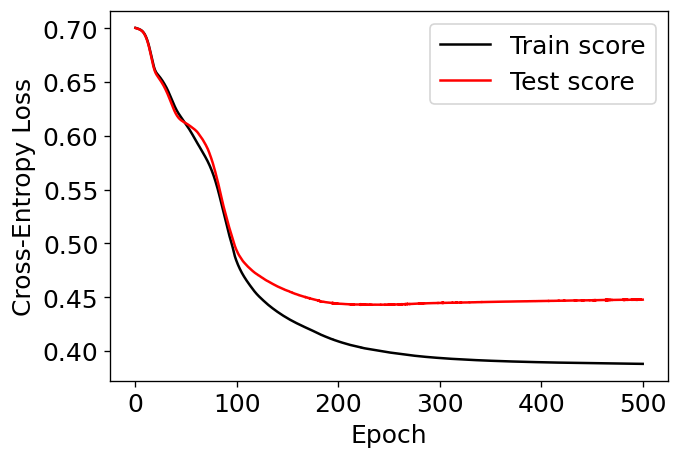

In [25]:
matplotlib.rcParams.update({'font.size': 15})
im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
ax.legend()
plt.show()

In [31]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

In [37]:
optim_index = np.argmin(np.array(loss_history_test))
print("Optimal epoch count for the current training:", optim_index//n_iterations)

outputs_optim = outputs_history_test[optim_index]
labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

outputclass_analysis(f_test, labels_optim)

Optimal epoch count for the current training: 222
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 103
TN = 184
FP = 19
FN = 24
Precision = 0.8442622950819673
Recall = 0.8110236220472441
Accuracy = 0.8696969696969697
TSS = 0.7174275629339436
HSS = 0.7227540932359032
